# Mathematical Underpinnings - Lab 7

In [88]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Task 1

### a)

In [89]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    '''
    Calculate KL divergence between two normal distributions - KL( p || q ),
    where:
        p ~ N(mu1, Sigma1)
        q ~ N(mu2, Sigma2)
    '''
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    n = len(mu1)
    Sigma2_inv = np.linalg.inv(Sigma2)
    return 0.5 * (np.transpose(mu2 - mu1) @ Sigma2_inv @ (mu2 - mu1) + np.trace(Sigma2_inv @ Sigma1) - n - np.log(np.linalg.det(Sigma1) / np.linalg.det(Sigma2)))


In [90]:
# Example
KL_mult_normal(np.array([1,0]),np.array([1,1]),np.array([[1,0],[0,1]]), np.array([[1,0],[0,1]]))

0.5

In [91]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    # density of multivariate normal distribution is e.g. here: https://en.wikipedia.org/wiki/Multivariate_normal_distribution
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = -np.log(np.linalg.det(Sigma1))/2 - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i,:] - mu1)), x[i,:] - mu1)/2
        st = np.log(np.linalg.det(Sigma2))/2 + np.dot(np.dot(np.linalg.inv(Sigma2), x[i,:] - mu2), x[i,:] - mu2)/2
        res[i] = ft+st
    return res

In [92]:
# Example
T_opt(np.array([[4,-1],[1,7]]),np.array([0,0]),np.array([1,1]),np.array([[2,1],[1,2]]), np.array([[1,0],[0,1]]))

array([-1.04930614,  3.11736052])

### b)

In [93]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)

In [94]:
n = 10000
mu1 = np.array([0.2, 0.2, 0.2, 0, 0])
mu2 = np.array([0, 0, 0.2, 0.2, 0.2])
rho1 = 0.1
rho2 = -0.2
Sigma1 = np.array([
    [1, rho1, rho1, rho1, rho1],
    [rho1, 1, rho1, rho1, rho1],
    [rho1, rho1, 1, rho1, rho1],
    [rho1, rho1, rho1, 1, rho1],
    [rho1, rho1, rho1, rho1, 1]
])
Sigma2 = np.array([
    [1, rho2, rho2, rho2, rho2],
    [rho2, 1, rho2, rho2, rho2],
    [rho2, rho2, 1, rho2, rho2],
    [rho2, rho2, rho2, 1, rho2],
    [rho2, rho2, rho2, rho2, 1]
])

samples1 = np.random.multivariate_normal(mu1, Sigma1, n)
samples2 = np.random.multivariate_normal(mu2, Sigma2, n)
X = np.concatenate((samples1, samples2),axis=0)
Y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))

KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [95]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1-y)
    return np.sum(t*y)/n1 - np.log(np.sum(np.exp(t)*(1-y))/n2)

In [96]:
estimator_T = np.array(T_opt(X,mu1, mu2, Sigma1, Sigma2))
DV_fun(Y,estimator_T)

2.3322740196926084

### c)

In [97]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term)

### d)

In [98]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [99]:
KL_hat = tf.keras.models.Sequential()
KL_hat.add(Dense(64, activation='softplus'))#, input_dim = x_train.shape[0]))
KL_hat.add(Dense(32, activation='softplus'))
KL_hat.add(Dense(1, activation='softplus'))

KL_hat.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), loss = DV_loss)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
hist = KL_hat.fit(x_train, y_train, epochs = 200, batch_size=n, callbacks=[early_stopping],  validation_data=(x_test, y_test))

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - loss: 0.0136 - val_loss: 0.0071
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0034 - val_loss: -0.0012
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: -0.0044 - val_loss: -0.0084
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.0114 - val_loss: -0.0150
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: -0.0179 - val_loss: -0.0213
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: -0.0244 - val_loss: -0.0276
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: -0.0308 - val_loss: -0.0340
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: -0.0368 - val_loss: -0.0403
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -0.0434 - val_loss: -0.0466
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: -0.0498 - val_loss: -0.0524
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: -0.0553 - val_loss: -0.0577
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - l

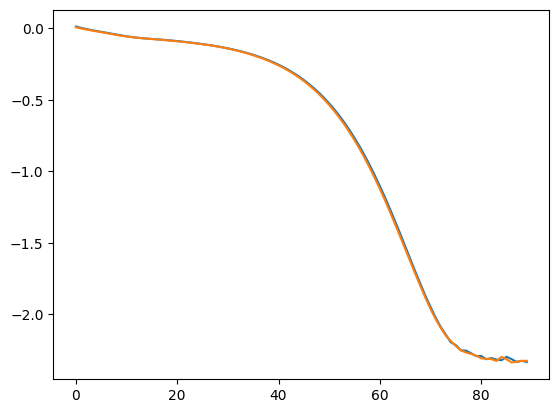

In [100]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [101]:
t_x_pred = KL_hat.predict(X)[:,0]
t_x_opt = T_opt(X, mu1, mu2, Sigma1, Sigma2)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


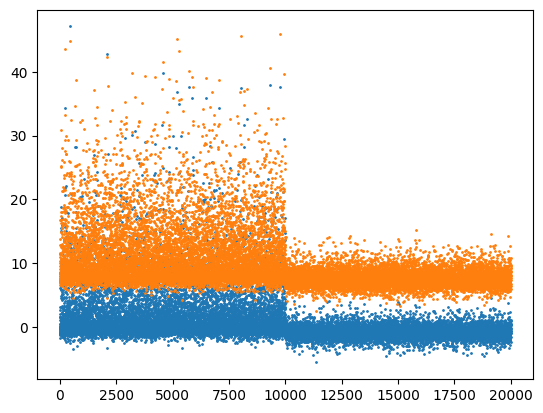

In [102]:
plt.scatter(np.arange(t_x_opt.shape[0]),t_x_opt, s=1)
plt.scatter(np.arange(t_x_opt.shape[0]),t_x_pred, s =1 )

plt.show()

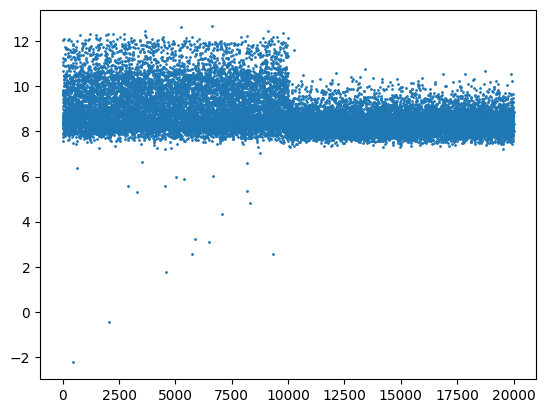

In [103]:
# Constant factor visual representation
plt.scatter(np.arange(t_x_opt.shape[0]),t_x_pred - t_x_opt, s =1 )

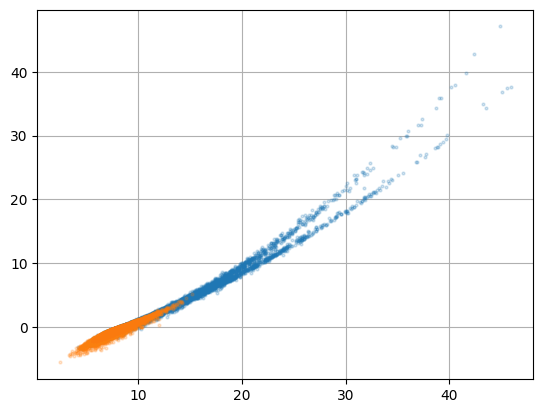

In [104]:
plt.plot(t_x_pred[Y==1], t_x_opt[Y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[Y==0], t_x_opt[Y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

In [105]:
DV_fun(Y, t_x_pred)

2.3390310682072446

In [106]:
DV_fun(Y, t_x_opt)

2.3322740196926084

In [107]:
# new data
n_new = 100000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [108]:
t_x_pred = KL_hat.predict(x_new)[:,0]
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


In [109]:
DV_fun(y_new, t_x_pred)

0.5425928938098252

In [110]:
DV_fun(y_new, t_x_opt)

1.980744422488022

### f)

In [111]:
def NWJ_loss(y_true, T_x):
   n1 = tf.math.reduce_sum(y_true)
   n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
   first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
   second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x - 1), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
   return -(first_term - second_term)

In [112]:
KL_hat = tf.keras.models.Sequential()
KL_hat.add(Dense(64, activation='softplus'))#, input_dim = x_train.shape[0]))
KL_hat.add(Dense(32, activation='softplus'))
KL_hat.add(Dense(1, activation='softplus'))

KL_hat.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), loss = NWJ_loss)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
hist = KL_hat.fit(x_train, y_train, epochs = 200, batch_size=n, callbacks=[early_stopping],  validation_data=(x_test, y_test))

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - loss: -0.9779 - val_loss: -0.9912
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: -0.9940 - val_loss: -1.0044
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: -1.0071 - val_loss: -1.0153
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: -1.0186 - val_loss: -1.0246
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: -1.0281 - val_loss: -1.0327
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: -1.0363 - val_loss: -1.0400
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: -1.0436 - val_loss: -1.0464
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: -1.0495 - val_loss: -1.0516
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: -1.0556 - val_loss: -1.0555
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: -1.0608 - val_loss: -1.0581
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: -1.0635 - val_loss: -1.0598
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step 

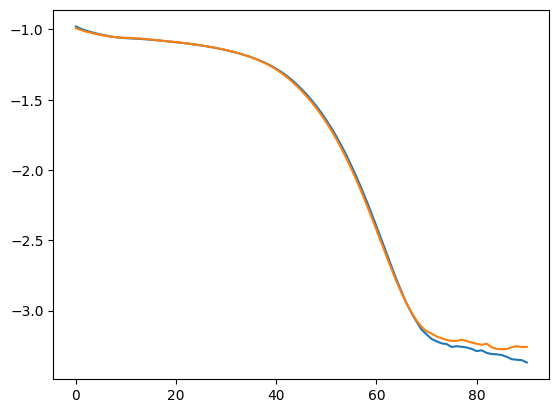

In [113]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [114]:
t_x_pred = KL_hat.predict(X)[:,0]
t_x_opt = T_opt(X, mu1, mu2, Sigma1, Sigma2)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


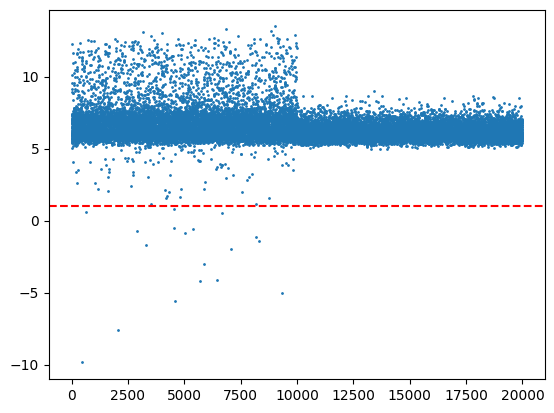

In [115]:
# Constant factor visual representation, in this case C = 1, not really why??
plt.scatter(np.arange(t_x_opt.shape[0]),t_x_pred - t_x_opt, s =1 )
plt.axhline(y=1, color='r', linestyle='--')

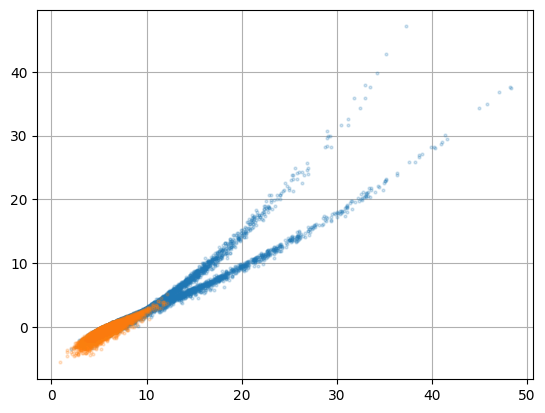

In [116]:
plt.plot(t_x_pred[Y==1], t_x_opt[Y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[Y==0], t_x_opt[Y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

In [117]:
DV_fun(Y, t_x_pred)

2.342585198172113

In [118]:
DV_fun(Y, t_x_opt)

2.3322740196926084

In [119]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [120]:
t_x_pred = KL_hat.predict(x_new)[:,0]
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [125]:
def NWJ_fun(y_true, T_x):
    n1 = np.sum(y_true)
    n2 = np.sum(1.0 - y_true)
    first_term = np.sum(np.multiply(T_x, y_true)) / n1
    second_term = np.log(np.sum(np.multiply(np.exp(T_x - 1), 1.0 - y_true)) / n2)
    return (first_term - second_term)

In [126]:
NWJ_fun(y_new, t_x_pred)

3.390041280179264

In [127]:
NWJ_fun(y_new, t_x_opt)

3.3950413564776163